# Data exploration of 10X PBMC Multiome data

The following files are needed to run this notebook:
1. **'pbmc10k.h5mu'** file containing ATAC and RNA MuData objects.
2. **'ctrl_peaks_1000x.npy'** file containing correlation of control peaks to focal gene.
3. **'n_ctrl_ct_1000x.npy'** files for n->(0,11) corresponding to correlation of control peaks to focal gene within each cell type.

## Load preprocessed data

In [71]:
# Importing libraries
import numpy as np
import pandas as pd 
import statsmodels.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scdrs
import math

import anndata as ad
import scanpy as sc
import muon as mu

In [72]:
# Since I preprocessed the data using Muon package, data is stored in Muon's hdf5-based .h5mu file.
mdata = mu.read('pbmc10k.h5mu')
mdata

KeyboardInterrupt: 

In [3]:
# Use intersect_obs to only retain samples that passed QC in both RNA and ATAC modality.
mu.pp.intersect_obs(mdata)
rna = mdata.mod['rna']
atac = mdata.mod['atac']

## Aligning peak-gene pair ATAC and RNA values
Normalized log1p data. Run this section to get gene labels for each peak and select the subset of peak-gene pairs present in both modalities.

In [4]:
# Normalized log1p data is stored in atac.X and rna.X as numpy arrays.
# We convert them to sparse arrays.
atac_Xs = sp.sparse.csc_array(atac.X)
rna_Xs = sp.sparse.csc_array(rna.X)

In [5]:
# We merge the peak annotations (closest gene to ATAC peak) provided by 10X genomics
peak_gene_labels = pd.merge(atac.var[['gene_ids']],atac.uns['atac']['peak_annotation'].reset_index(),how='left',left_on='gene_ids',right_on='peak')
peak_gene_labels = peak_gene_labels.drop_duplicates(subset='peak').reset_index(drop=True)
peak_gene_labels.head()

,gene_ids,gene_name,peak,distance,peak_type
0,chr1:9790-10675,MIR1302-2HG,chr1:9790-10675,-18879,distal
1,chr1:180599-181702,AL627309.5,chr1:180599-181702,-6738,distal
2,chr1:191168-192093,AL627309.5,chr1:191168-192093,-17307,distal
3,chr1:267565-268455,AP006222.2,chr1:267565-268455,711,distal
4,chr1:270876-271770,AP006222.2,chr1:270876-271770,4022,distal


In [6]:
# Duplicates for multiple peaks per gene, but skips ones not observed in RNA
peak_gene_pairs = pd.merge(peak_gene_labels,rna.var_names.to_frame(index=False).reset_index(),how='left',left_on='gene_name',right_on=0).dropna(subset=0)
peak_gene_pairs

,gene_ids,gene_name,peak,distance,peak_type,index,0
1,chr1:180599-181702,AL627309.5,chr1:180599-181702,-6738,distal,1.0,AL627309.5
2,chr1:191168-192093,AL627309.5,chr1:191168-192093,-17307,distal,1.0,AL627309.5
10,chr1:774742-775615,LINC01409,chr1:774742-775615,-3143,distal,4.0,LINC01409
11,chr1:778283-779200,LINC01409,chr1:778283-779200,0,promoter,4.0,LINC01409
12,chr1:816877-817776,FAM87B,chr1:816877-817776,0,promoter,5.0,FAM87B
...,...,...,...,...,...,...,...
143867,KI270721.1:2092-2983,AC004556.3,KI270721.1:2092-2983,0,promoter,26338.0,AC004556.3
143868,KI270721.1:3646-4418,AC004556.3,KI270721.1:3646-4418,1062,distal,26338.0,AC004556.3
143869,KI270721.1:8382-9256,AC004556.3,KI270721.1:8382-9256,5798,distal,26338.0,AC004556.3
143873,KI270711.1:7923-8714,AC240274.1,KI270711.1:7923-8714,15936,distal,26337.0,AC240274.1


In [7]:
# We choose the columns which overlap with RNAseq genes
atac_Xs = atac_Xs[:,peak_gene_pairs.index.values]
atac_Xs

<9632x127357 sparse array of type '<class 'numpy.float32'>'
	with 1226702624 stored elements in Compressed Sparse Column format>

In [8]:
# We choose columns that overlap with RNAseq genes AND repeat those 
# that have multiple peaks in ATAC modality
occurences = peak_gene_pairs['index'].astype(int).values
rna_Xs = rna_Xs[:,occurences]

In [9]:
# Now, shape should be same.
print(atac_Xs.shape, rna_Xs.shape)

(9632, 127357) (9632, 127357)


## Raw data
Non-normalized log1p data. I used this to plot my data rather than the normalized atac_Xs and rna_Xs.

In [10]:
# Non-normalized data is also stored in atac.raw.X as sparse matrices
raw_atac_X = atac.raw.X[:,peak_gene_pairs.index.values]
raw_rna_X = rna.raw.X[:,occurences]
print(raw_atac_X.shape,raw_rna_X.shape)

(9632, 127357) (9632, 127357)


## Pearson correlation
This is our implementation of pearson correlation.

In [24]:
# from Martin (original from scdrs)

def pearson_corr_sparse(mat_X, mat_Y, var_filter=False):
    """Pairwise Pearson's correlation between columns in mat_X and mat_Y (sparse matrix)

    Parameters
    ----------
    mat_X : np.ndarray
        First matrix of shape (N,M).
    mat_Y : np.ndarray
        Second matrix of shape (N,M).
    * Added:
    var_filter : boolean
        Dictates whether to filter out columns with little to no variance.

    Returns
    -------
    mat_corr : np.ndarray
        Correlation array of shape (M,).
    * Added:
    no_var : np.ndarray
        A boolean mask where False represents excluded columns of mat_X and mat_Y of shape (N,M).
        
    """

    # Reshape
    if len(mat_X.shape) == 1:
        mat_X = mat_X.reshape([-1, 1])
    if len(mat_Y.shape) == 1:
        mat_Y = mat_Y.reshape([-1, 1])

    # Convert to sparse matrix if not already sparse
    if sp.sparse.issparse(mat_X) is False:
        mat_X = sp.sparse.csr_matrix(mat_X)
    if sp.sparse.issparse(mat_Y) is False:
        mat_Y = sp.sparse.csr_matrix(mat_Y)
    
    # Compute v_mean,v_var
    
    v_X_mean, v_X_var = scdrs.pp._get_mean_var(mat_X, axis=0)
    v_Y_mean, v_Y_var = scdrs.pp._get_mean_var(mat_Y, axis=0) 
    
    no_var = (v_X_var <= 1e-6) | (v_Y_var <= 1e-6)
    
    # This section removes columns with little to no variance.
    if var_filter and np.any(no_var):

        mat_X, mat_Y = mat_X[:,~no_var], mat_Y[:,~no_var]
        v_X_mean, v_X_var = v_X_mean[~no_var], v_X_var[~no_var]
        v_Y_mean, v_Y_var = v_Y_mean[~no_var], v_Y_var[~no_var]
        
    v_X_sd = np.sqrt(v_X_var)
    v_Y_sd = np.sqrt(v_Y_var)
    
    # Adjusted for column pairwise correlation only
    mat_corr = mat_X.multiply(mat_Y).mean(axis=0)
    mat_corr = mat_corr - v_X_mean * v_Y_mean
    mat_corr = mat_corr / v_X_sd / v_Y_sd

    mat_corr = np.array(mat_corr, dtype=np.float32)

    if (mat_X.shape[1] == 1) | (mat_Y.shape[1] == 1):
        return mat_corr.reshape([-1])
    if var_filter:
        return mat_corr, ~no_var

    return mat_corr

# P-value calculation

In [25]:
def mc_pval(del_cctrl,del_c):
    
    ''' Calculates Monte Carlo p-value
    
    Parameters
    ----------
    del_cctrl : np.ndarray
        Matrix of shape (gene#,n) where n is number of rand samples.
    del_c : np.ndarray
        Vector of shape (gene#,), which gets reshaped to (gene#,1).
    
    Returns
    ----------
    Vector of shape (gene#,) corresponding to the Monte Carlo p-value of each statistic.
    
    '''

    indicator = np.sum(np.abs(del_cctrl) >= np.abs(del_c.reshape(-1, 1)), axis=1)
    return (1+indicator)/(1+del_cctrl.shape[1])

In [ ]:
def zscore_pval(del_cctrl,del_c):

    ''' Calculates Z-score based p-value.
    
    Parameters
    ----------
    del_cctrl : np.ndarray
        Matrix of shape (gene#,n) where n is number of rand samples.
    del_c : np.ndarray
        Vector of shape (gene#,), which gets reshaped to (gene#,1).
    
    Returns
    ----------
    Vector of shape (gene#,) corresponding to the Z-score based p-value of each statistic.
    
    '''

    mean = np.mean(del_cctrl,axis=1)
    sd = np.std(del_cctrl,axis=1)
    z = (del_c - mean)/sd
    
    return 1-sp.stats.norm.cdf(z)

## Calculating correlation and MC p-value across all cells
If you would like to use my precomputed control peaks you can load them here:

In [75]:
ctrl_corr = np.load('ctrl_peaks/ctrl_peaks_1000x.npy')
ctrl_corr.shape

(127357, 1000)

In [28]:
# Setting var_filter = True excludes variables that have little to no variance
corr = pearson_corr_sparse(atac_Xs, rna_Xs, var_filter=True)

/home/asprieto/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


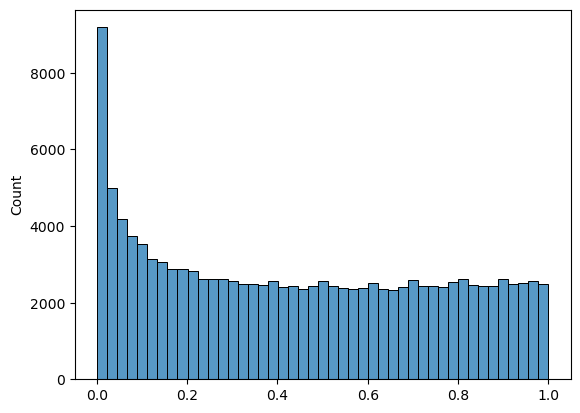

In [31]:
all_pval = mc_pval(ctrl_corr[corr[1],:],corr[0])
all_qvals = stats.multitest.multipletests(all_pval, alpha=0.05, method='fdr_bh')
sns.histplot(data=all_pval);

In [34]:
# A labelled DataFrame of peak-gene pair results
all_pvals_df = pd.DataFrame(data={'peak_name':peak_gene_pairs.loc[corr[1]].gene_ids.values, \
                                  'gene_name':peak_gene_pairs.loc[corr[1]].gene_name.values, \
                                  'distance':peak_gene_pairs.loc[corr[1]].distance.values, \
                                  'all_pval':all_pval,'all_qval':all_qvals[1],'corr':corr[0]})
all_pvals_df.head()

,peak_name,gene_name,distance,all_pval,all_qval,corr
0,chr1:180599-181702,AL627309.5,-6738,0.344655,0.804434,-0.019674
1,chr1:191168-192093,AL627309.5,-17307,0.908092,0.988823,0.007619
2,chr1:774742-775615,LINC01409,-3143,0.857143,0.981292,-0.001954
3,chr1:778283-779200,LINC01409,0,0.022977,0.318173,-0.021723
4,chr1:816877-817776,FAM87B,0,0.985015,0.997730,0.000783


## Calculating correlation and MC p-value for each CT

In [40]:
labels = [
    'CD4+ naïve T', 'CD4+ memory T', 'MAIT',
    'CD8+ naïve T', 'CD8+ activated T', 'NK',
    'naïve B', 'memory B',
    'CD14 mono', 'intermediate mono', 'mDC', 'pDC']

In [59]:
def ct_corr_pval(ct_label,ctrl_corr_npy,pval_method=mc_pval):
    
    ''' Calculates correlation and p-value for a given CT.
    
    Parameters
    ----------
    ct_label : list of strings
        A list of length (# of CTs) corresponding to the CT label.
    ctrl_corr_npy : string
        A string corresponding to the .npy file in which CT-specific
        control peak-gene correlations are stored. Must specify path.
    pval_method : function
        A function that takes in two np.ndarrays of length (N,B) and (N,)
        to calculate p-value.
    
    Returns
    ----------
    ct_dict : Dictionary
        A dictionary containing the gene_ids, gene_name, distance, delta_corr,
        and pval_method for the given CT.
        
    '''
    
    # Select samples of focal CT
    ct_mask = (rna.obs.celltype.values == ct_label) & (atac.obs.celltype.values == ct_label)
    ct_rnaX, ct_atacX = rna_Xs[ct_mask,:], atac_Xs[ct_mask,:]
    
    # Remove lowly accessible/expressed peak-genes from both matrices
    lowexp_mask = (ct_atacX.mean(axis=0) > 0.1) & (ct_rnaX.mean(axis=0) > 0.1)
    ct_rnaX, ct_atacX = ct_rnaX[:,lowexp_mask], ct_atacX[:,lowexp_mask]
    
    # Calculate their correlation
    corr_ct = pearson_corr_sparse(ct_atacX, ct_rnaX, var_filter=True)
    
    # Calculate delta corr while filtering out lowly access./express.
    corr_all = pearson_corr_sparse(atac_Xs[:,lowexp_mask], rna_Xs[:,lowexp_mask])
    delta_corr = corr_all[corr_ct[1]] - corr_ct[0]
    # Delta corr of ctrl peaks
    ctrl_corr_ct = np.load(ctrl_corr_npy)[lowexp_mask,:][corr_ct[1],:]
    delta_corr_ctrl = ctrl_corr[lowexp_mask,:][corr_ct[1],:] - ctrl_corr_ct
    
    # MC pvalue
    ct_mc_pval = pval_method(delta_corr_ctrl,delta_corr)
    
    # Save info in dictionary
    ct_dict = peak_gene_pairs[['gene_ids','gene_name','distance']].loc[lowexp_mask].loc[corr_ct[1]].to_dict('list')

    ct_dict['delta_corr'] = delta_corr
    ct_dict[pval_method.__name__] = ct_mc_pval
    
    return ct_dict
        

In [74]:
cd4nt_dict = ct_corr_pval(labels[0],'ctrl_peaks/0_ctrl_ct_1000x.npy')
pd.DataFrame(cd4nt_dict)

,gene_ids,gene_name,distance,delta_corr,mc_pval
0,chr1:2227386-2228299,SKI,-20,0.028787,0.317682
1,chr1:2230816-2231568,SKI,2498,0.022315,0.455544
2,chr1:2231702-2232553,SKI,3384,0.024093,0.489510
3,chr1:2236949-2237824,SKI,8631,0.062700,0.066933
4,chr1:2240132-2240993,SKI,11814,-0.024016,0.388611
...,...,...,...,...,...
4018,chrX:136689214-136690057,CD40LG,40988,0.045199,0.267732
4019,chrX:136880313-136881143,RBMX,0,-0.001706,0.953047
4020,chrX:154476665-154477465,LAGE3,1792,0.009717,0.738262
4021,GL000219.1:42163-43054,AL592183.1,40257,0.034363,0.272727


In [69]:
ct_dicts = []

for k in np.arange(12):
    ct_dicts += [ct_corr_pval(labels[k], 'ctrl_peaks/'+str(k)+'_ctrl_ct_1000x.npy')]

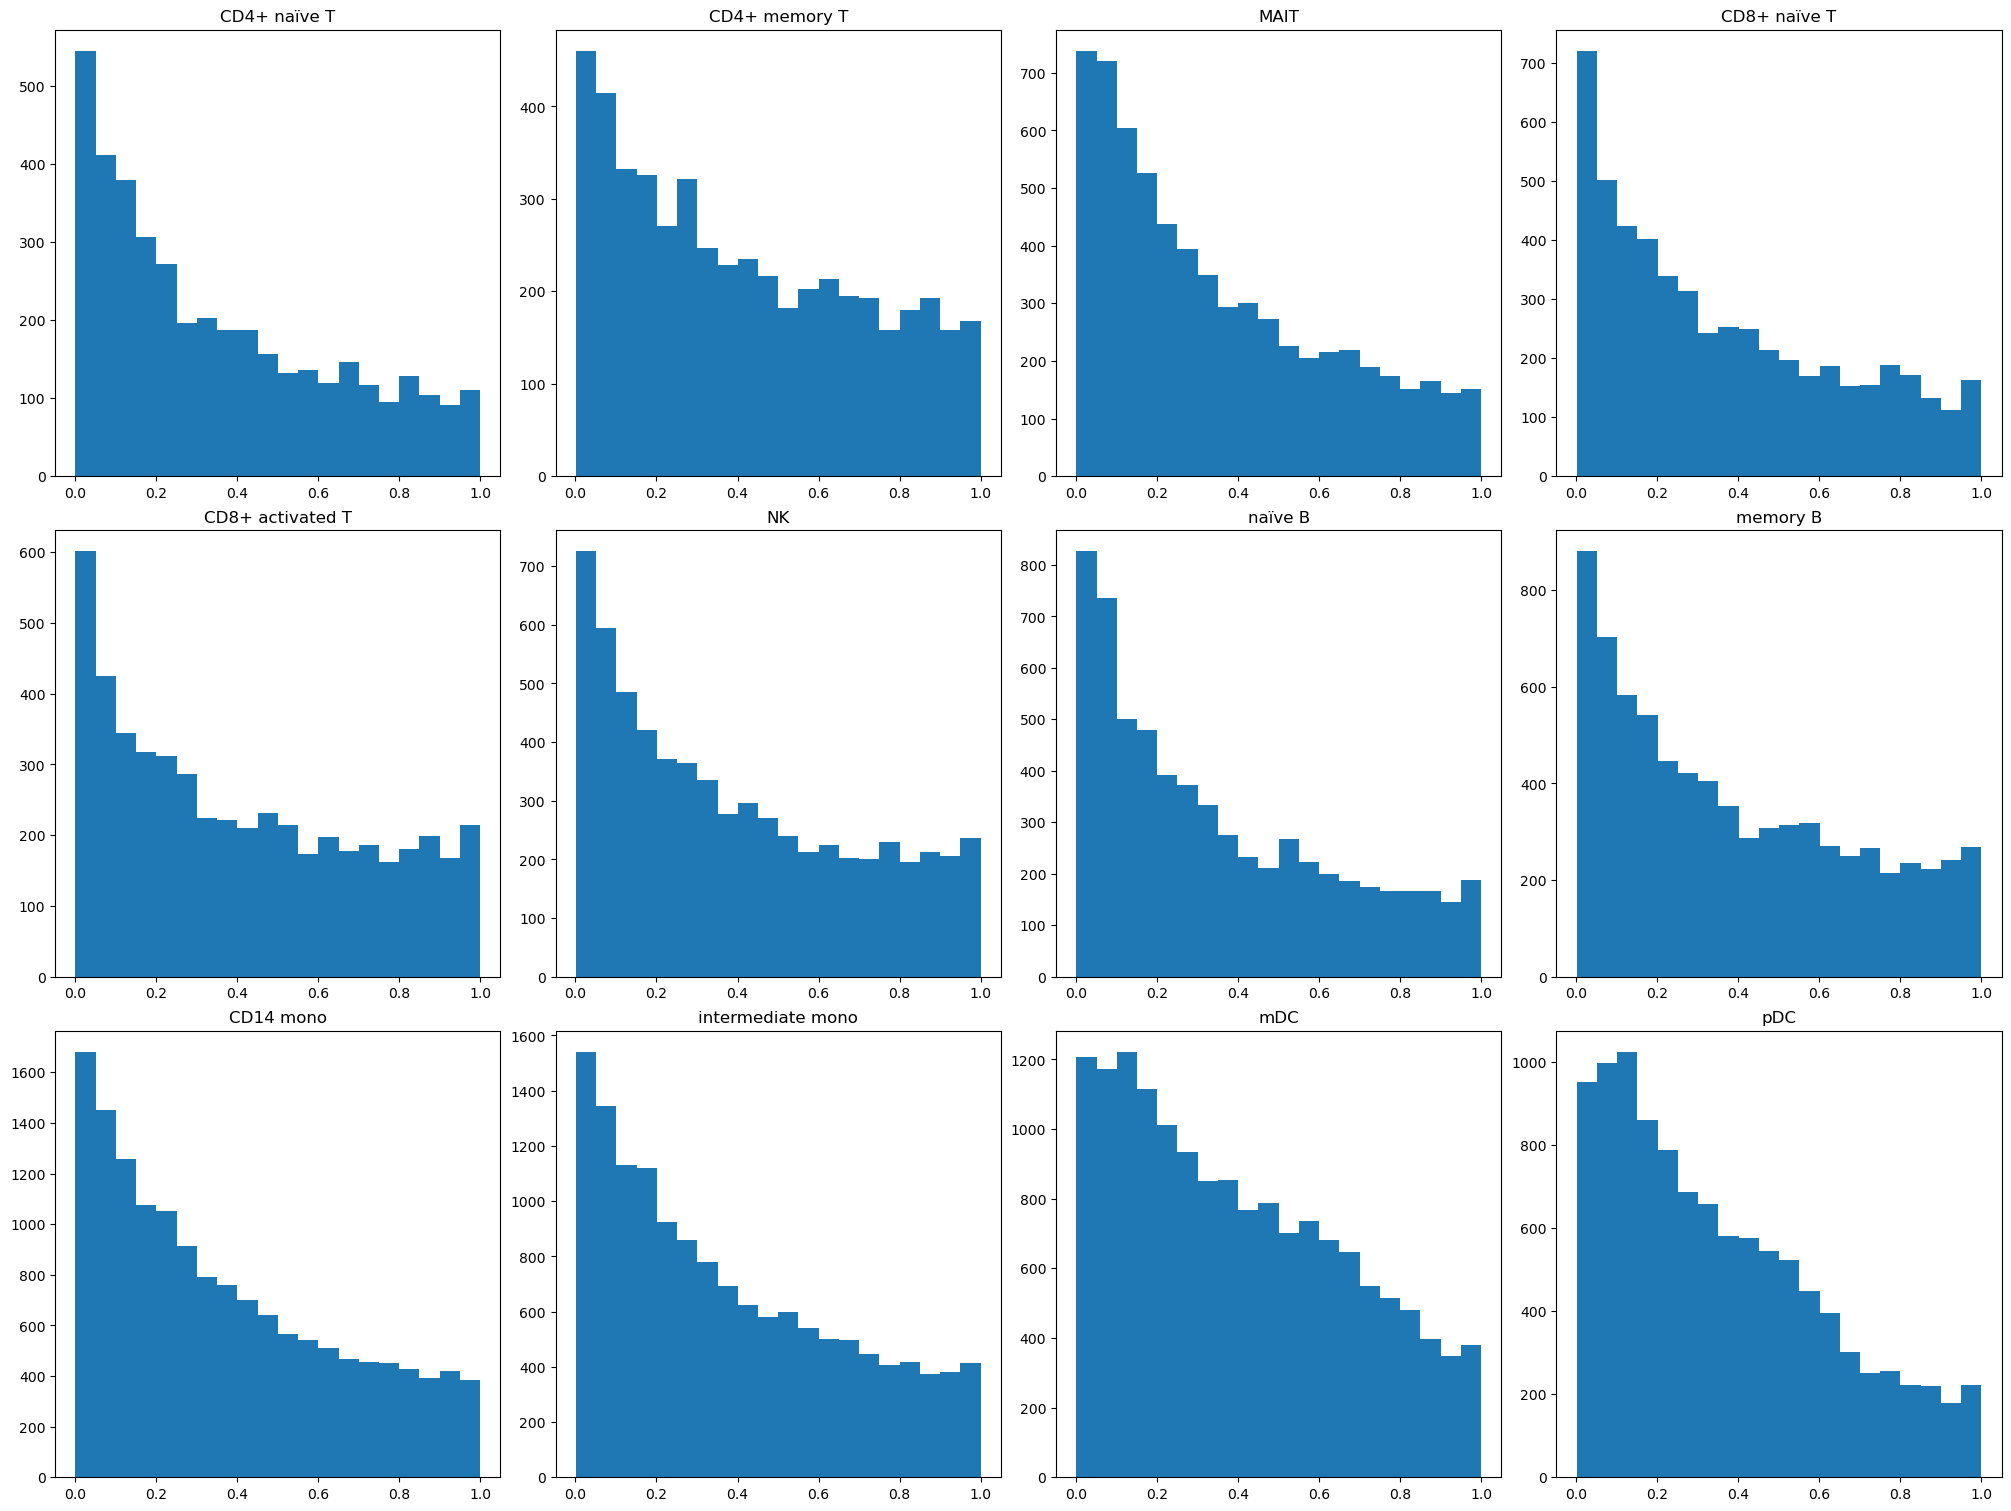

In [70]:
fig, axs = plt.subplots(3,4,layout='constrained')

fig.set_figheight(15)
fig.set_figwidth(20)

k=0
for ax in axs.reshape(-1):
    ax.hist(ct_dicts[k]['mc_pval'],bins=20)
    ax.set_title(labels[k])
    k+=1

plt.show()